In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd
import numpy as np
import math

import seaborn as sns

from downstream.signals.signal_r2_permutation_test import process, collect_paths

/Users/romeo/anaconda/envs/aging3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
datatype_loci = {
    "H3K4me1": ["cd14v2_chromhmm18.hg19.8_EnhG2", "cd14v2_chromhmm18.hg19.9_EnhA1"],
    "H3K4me3": ["cd14v2_chromhmm18.hg19.1_TssA", "cd14v2_chromhmm18.hg19.2_TssFlnk"],
    "H3K27ac": ["cd14v2_chromhmm18.hg19.1_TssA", "cd14v2_chromhmm18.hg19.3_TssFlnkU"],
    "H3K36me3": ["cd14v2_chromhmm18.hg19.5_Tx", "cd14v2_chromhmm18.hg19.7_EnhG1",
                 "cd14v2_chromhmm18.hg19.8_EnhG2"],
    "H3K27me3": ["cd14v2_chromhmm18.hg19.14_TssBiv", "cd14v2_chromhmm18.hg19.15_EnhBiv",
                 "cd14v2_chromhmm18.hg19.16_ReprPC"],
    "meth" : ["ucsc_cpgIslandExt.hg19", "cpg_minavcov10_complex_4outliers.narrow.adjusted.regions.filtered"]
}
for dt, loci in datatype_loci.items():
    loci.append("random1000x10000")
    loci.append("hg19_100000")
    if dt.startswith("H"):
        loci.append("{}_zinbra_median_consensus".format(dt))
        loci.append("{}_zinbra_weak_consensus".format(dt))
        
signals_root = Path("/mnt/stripe/bio/experiments/signal_experiments")

In [3]:
folders = [signals_root / dt / loci for dt in sorted(datatype_loci.keys()) for loci in datatype_loci[dt]]
print("Loci folders: ", *[str(p) for p in folders], sep="\n  ")

paths = [p for folder in folders for p in collect_paths(folder)]
print("Paths: ", len(paths))

Loci folders: 
  /mnt/stripe/bio/experiments/signal_experiments/H3K27ac/cd14v2_chromhmm18.hg19.1_TssA
  /mnt/stripe/bio/experiments/signal_experiments/H3K27ac/cd14v2_chromhmm18.hg19.3_TssFlnkU
  /mnt/stripe/bio/experiments/signal_experiments/H3K27ac/random1000x10000
  /mnt/stripe/bio/experiments/signal_experiments/H3K27ac/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiments/H3K27ac/H3K27ac_zinbra_median_consensus
  /mnt/stripe/bio/experiments/signal_experiments/H3K27ac/H3K27ac_zinbra_weak_consensus
  /mnt/stripe/bio/experiments/signal_experiments/H3K27me3/cd14v2_chromhmm18.hg19.14_TssBiv
  /mnt/stripe/bio/experiments/signal_experiments/H3K27me3/cd14v2_chromhmm18.hg19.15_EnhBiv
  /mnt/stripe/bio/experiments/signal_experiments/H3K27me3/cd14v2_chromhmm18.hg19.16_ReprPC
  /mnt/stripe/bio/experiments/signal_experiments/H3K27me3/random1000x10000
  /mnt/stripe/bio/experiments/signal_experiments/H3K27me3/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiments/H3K27me3/H3K27me3_zin

In [8]:
# simulations = 6
simulations = 100001
output_path = signals_root / "validate.norms.permutation_r2.{}.csv".format(simulations)
output_path

print(str(output_path), "[exists]" if output_path.exists() else "[not exists]")

/mnt/stripe/bio/experiments/signal_experiments/validate.norms.permutation_r2.100001.csv [exists]


In [9]:
if not output_path.exists():
    process(paths, str(output_path), seed=100, simulations=simulations, threads=8)
print("Results file: ", str(output_path))

Results file:  /mnt/stripe/bio/experiments/signal_experiments/validate.norms.permutation_r2.100001.csv


In [10]:
df = pd.DataFrame.from_csv(output_path, index_col=None)
df["loci"] = [Path(f).name for f in df["file"]]
print("Shape:", df.shape)
df.head(10)

Shape: (333, 9)


,modification,file,normalization,mean,median,p2,p5,p10,loci
0,H3K27ac,/mnt/stripe/bio/experiments/signal_experiments...,frip,0.922315,0.968264,0.540931,0.723086,0.811906,H3K27ac_zinbra_median_consensus
1,H3K27ac,/mnt/stripe/bio/experiments/signal_experiments...,fripm,0.992428,0.993499,0.980297,0.983789,0.986720,H3K27ac_zinbra_median_consensus
2,H3K27ac,/mnt/stripe/bio/experiments/signal_experiments...,fripq,0.994338,0.995096,0.985821,0.988172,0.990207,H3K27ac_zinbra_median_consensus
3,H3K27ac,/mnt/stripe/bio/experiments/signal_experiments...,fripz,0.994043,0.994858,0.984609,0.987458,0.989604,H3K27ac_zinbra_median_consensus
4,H3K27ac,/mnt/stripe/bio/experiments/signal_experiments...,raw,0.930656,0.970846,0.590816,0.750969,0.831836,H3K27ac_zinbra_median_consensus
5,H3K27ac,/mnt/stripe/bio/experiments/signal_experiments...,rawq,0.994338,0.995096,0.985821,0.988172,0.990207,H3K27ac_zinbra_median_consensus
6,H3K27ac,/mnt/stripe/bio/experiments/signal_experiments...,rawz,0.994043,0.994858,0.984609,0.987458,0.989604,H3K27ac_zinbra_median_consensus
7,H3K27ac,/mnt/stripe/bio/experiments/signal_experiments...,rpkm,0.633235,0.823931,-0.917134,-0.216881,0.155801,H3K27ac_zinbra_median_consensus
8,H3K27ac,/mnt/stripe/bio/experiments/signal_experiments...,rpm,0.932011,0.969384,0.605086,0.751339,0.836483,H3K27ac_zinbra_median_consensus
9,H3K27ac,/mnt/stripe/bio/experiments/signal_experiments...,scores,0.990911,0.992606,0.971444,0.978614,0.983778,H3K27ac_zinbra_median_consensus


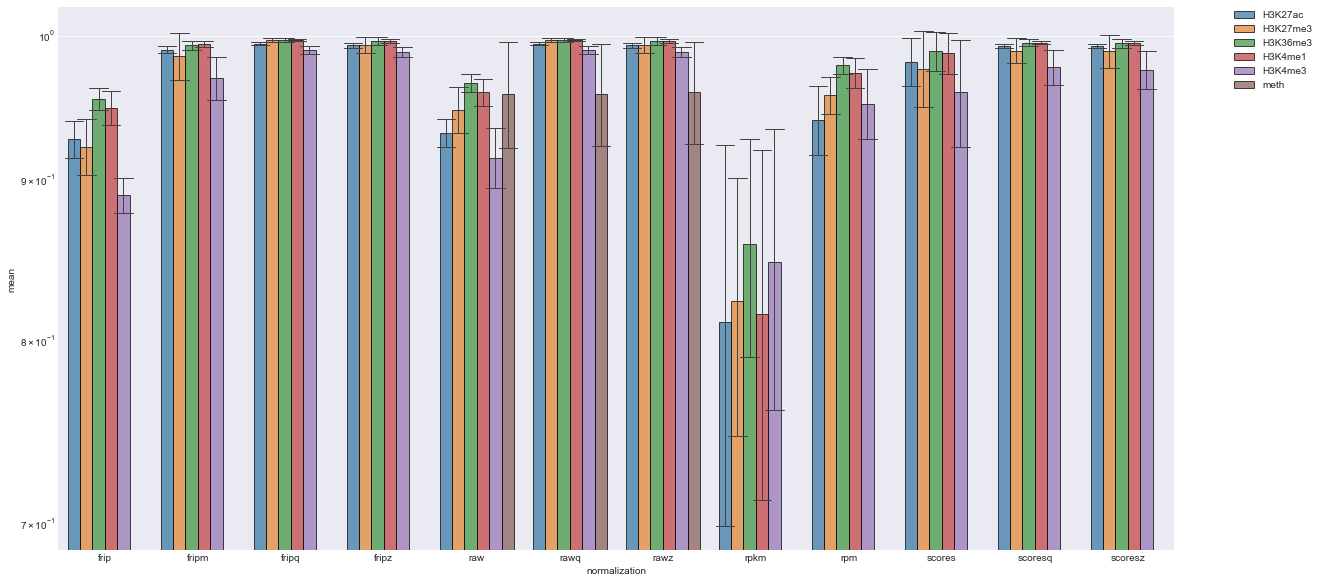

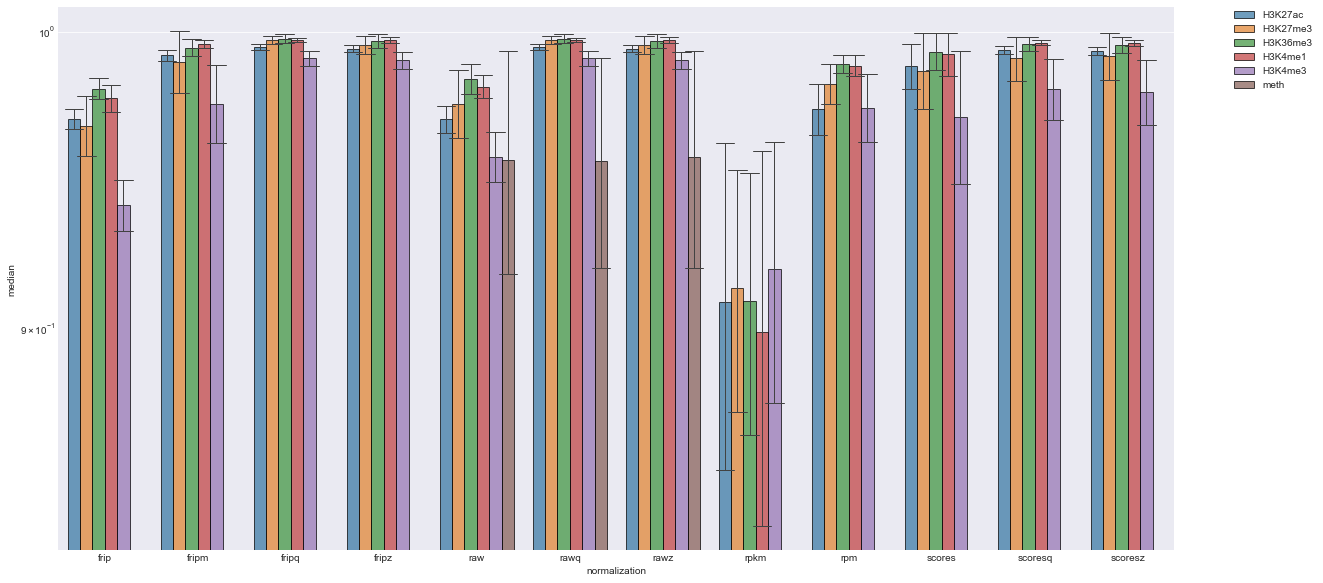

In [11]:
for metric in ["mean", "median"]:
    plt.figure(figsize=(20,10))
    g = sns.barplot(data=df, y=metric, x="normalization",
                    hue="modification", #order=sorted(datatype_loci.keys()),
                    ci="sd", capsize=.2, errwidth=1, # error bars
                    #color="lightgray", 
                    alpha=0.7,
                    edgecolor="black")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    g.set_yscale('log')

    plt.show()

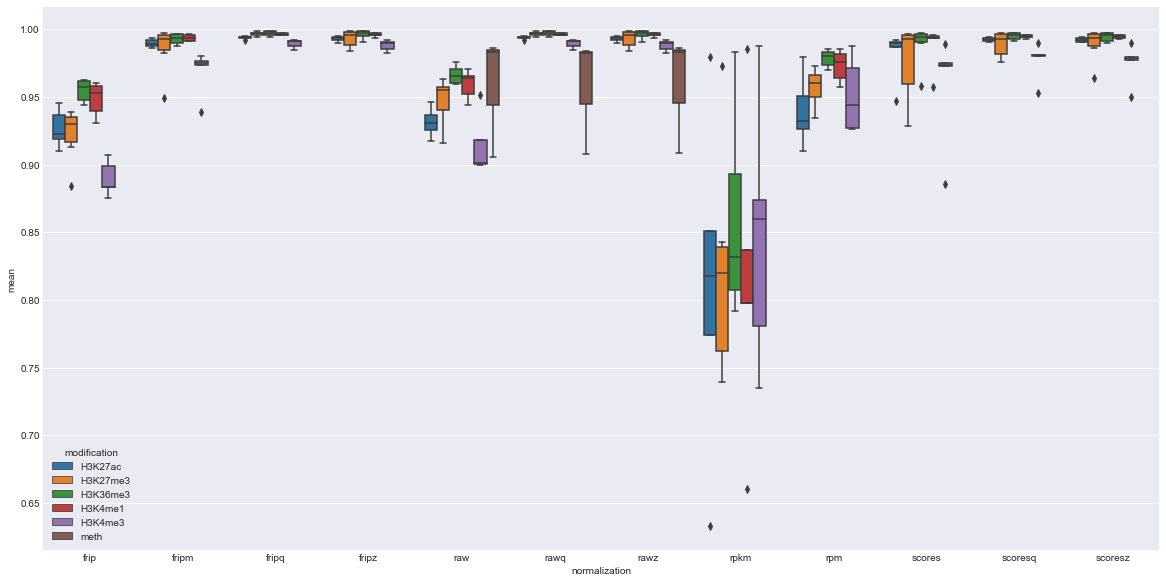

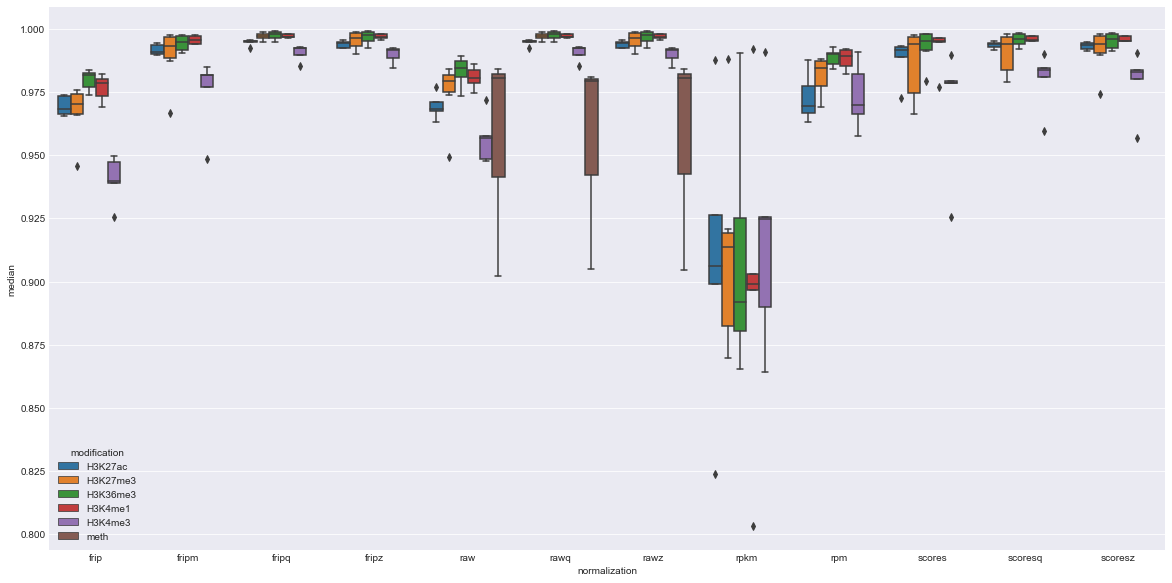

In [12]:
for metric in ["mean", "median"]:
    plt.figure(figsize=(20,10))
    ax = sns.boxplot(data=df, y=metric, hue="modification", x="normalization")
    plt.show()

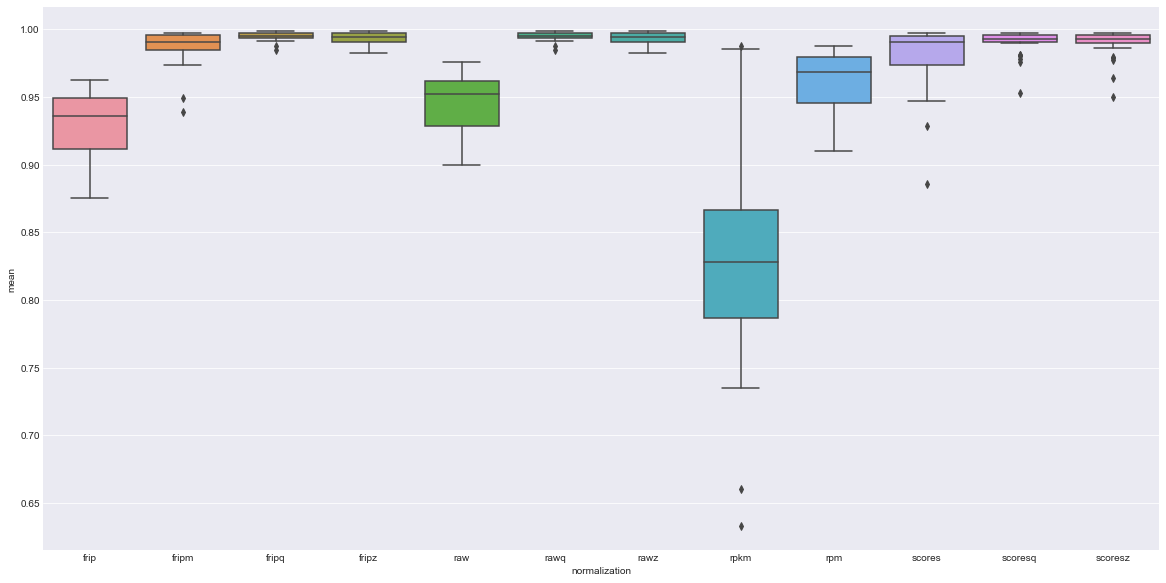

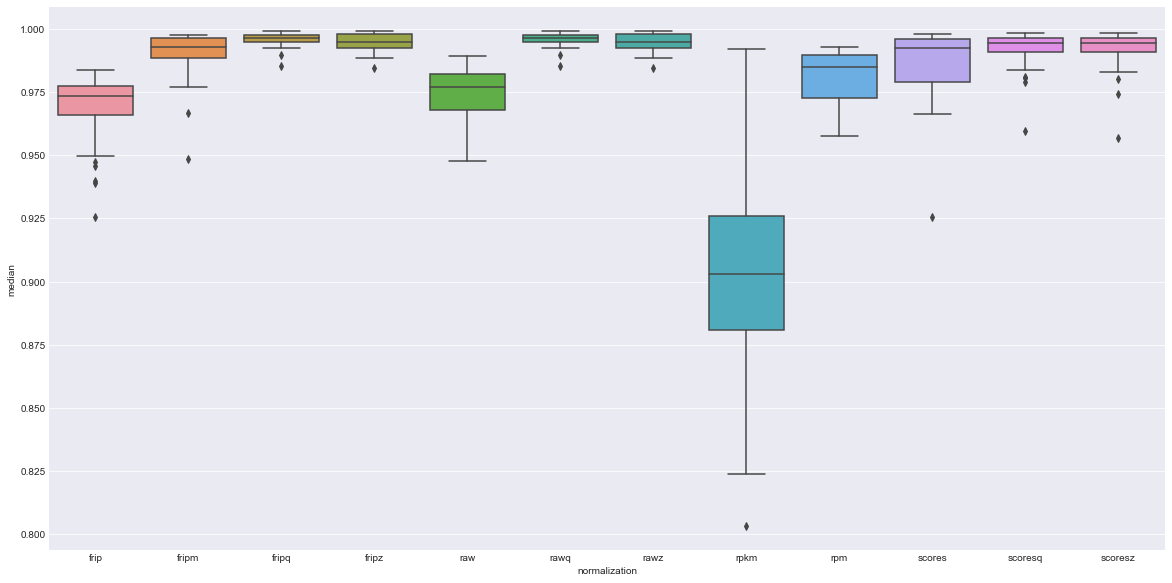

In [13]:
for metric in ["mean", "median"]:
    plt.figure(figsize=(20,10))
    ax = sns.boxplot(data=df[df.modification != "meth"], 
                     y=metric, x="normalization")
    plt.show()

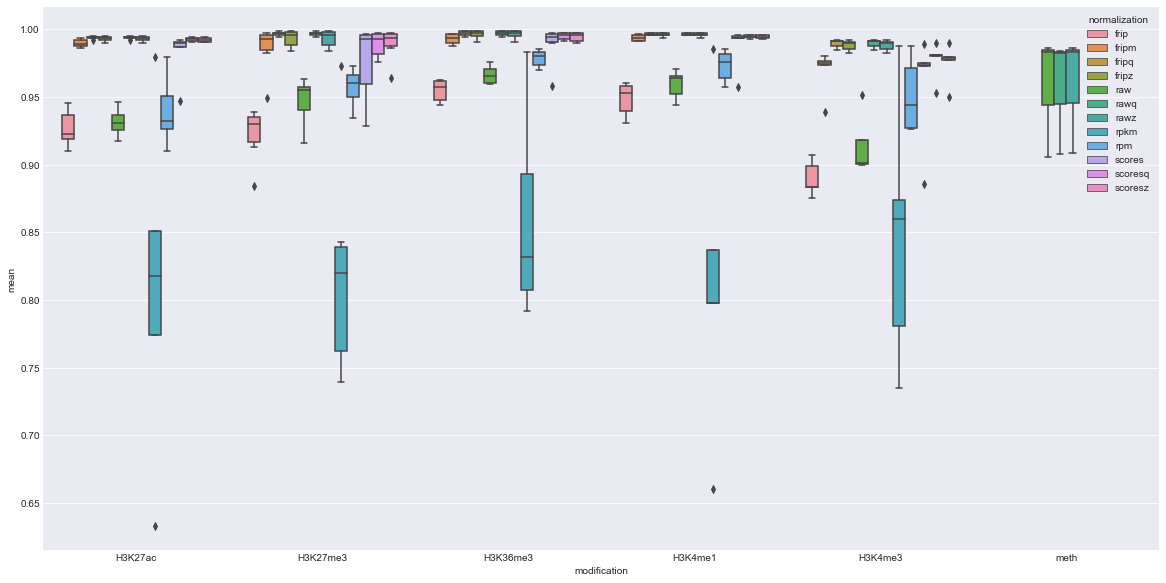

In [14]:
plt.figure(figsize=(20,10))
g = sns.boxplot(data=df, y="mean", x="modification", hue="normalization")
plt.show()

/Users/romeo/anaconda/envs/aging3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


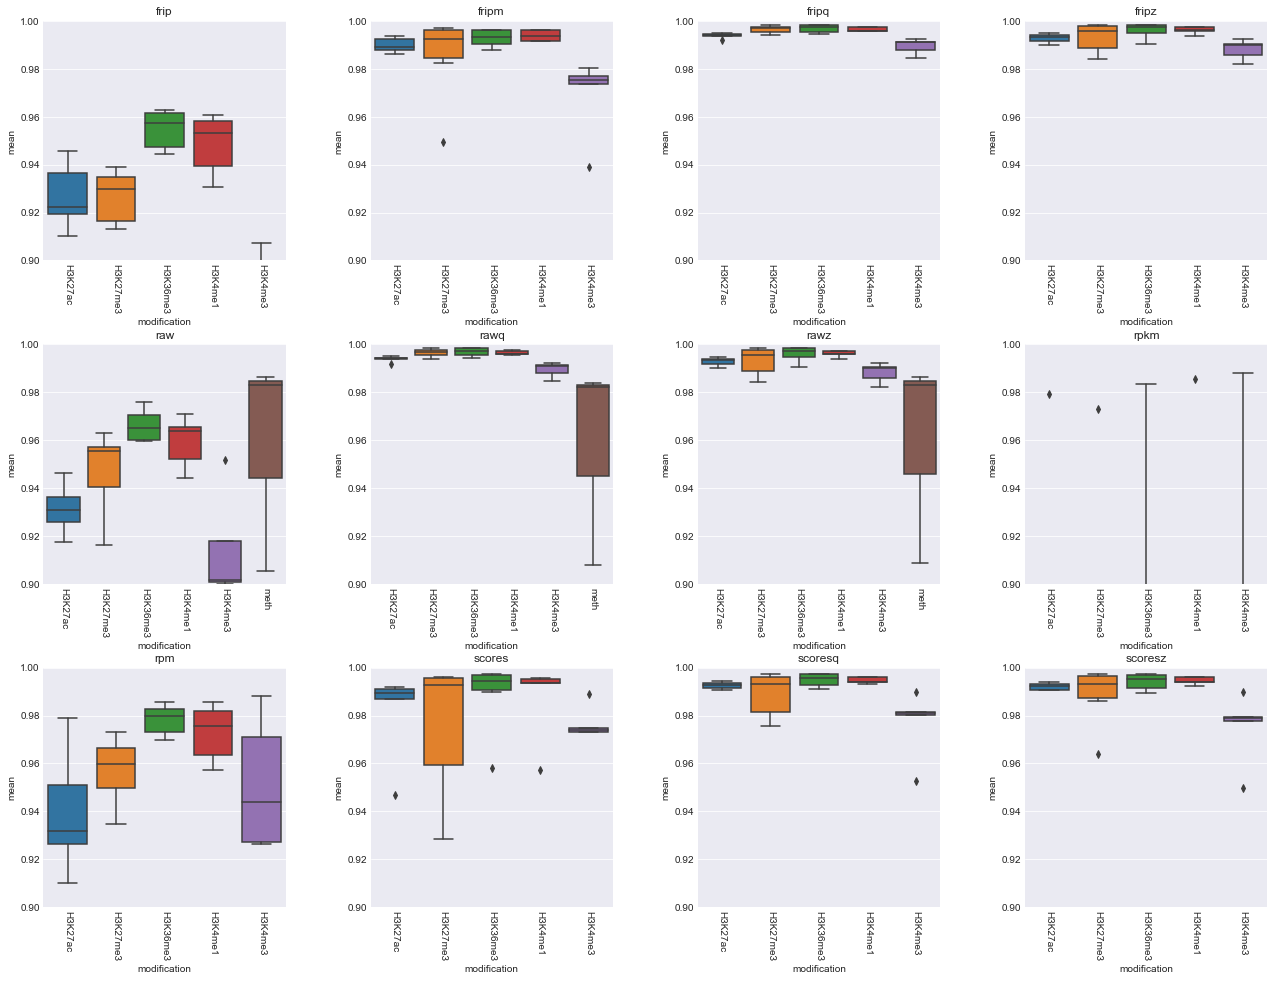

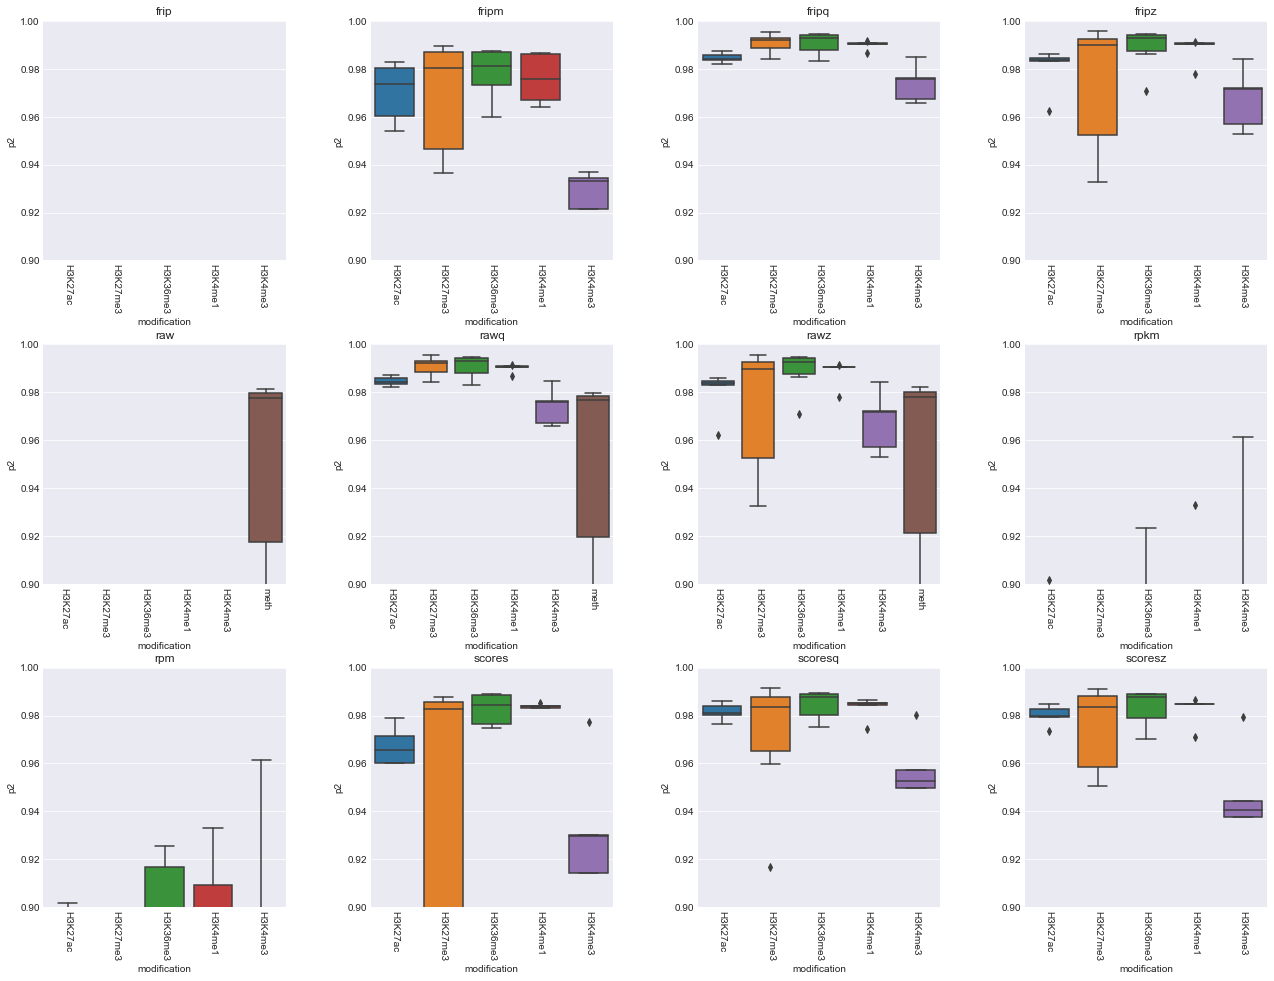

In [37]:
norms = sorted(set(df["normalization"]))
n_subplots = math.ceil(np.sqrt(len(norms)))
for metric in ["mean", "p2"]:
    plt.figure(figsize=(n_subplots*5, n_subplots*5))
    
    for i, norm in enumerate(norms, 1):
        ax = plt.subplot(n_subplots, n_subplots, i)
        g = sns.boxplot(data=df[df["normalization"] == norm], y=metric, x="modification",
                        ax=ax)
        for item in g.get_xticklabels():
            item.set_rotation(-90)
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax.set_title(norm)
        ax.set_ylim(0.9, 1.0)
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
    plt.show()


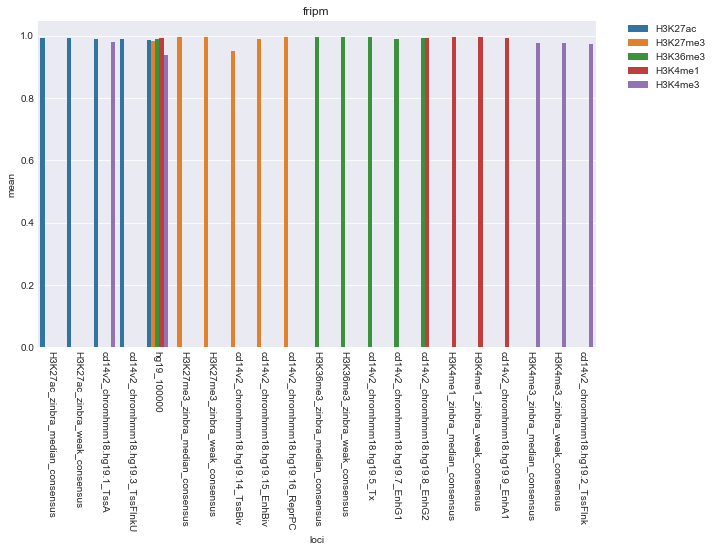

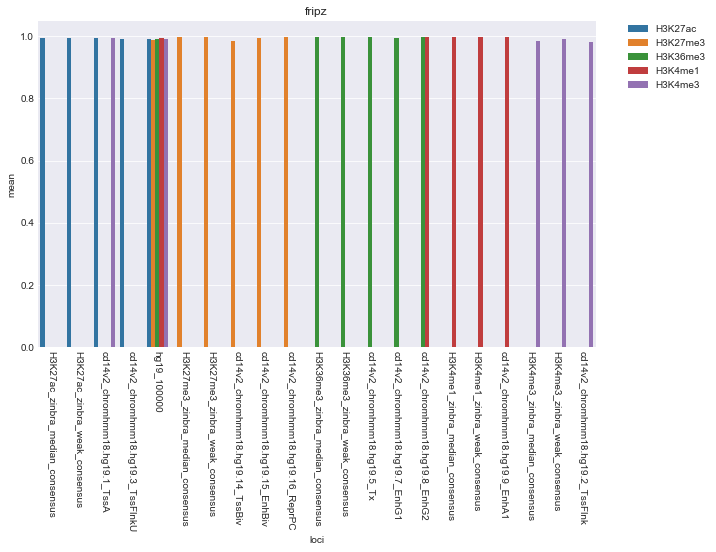

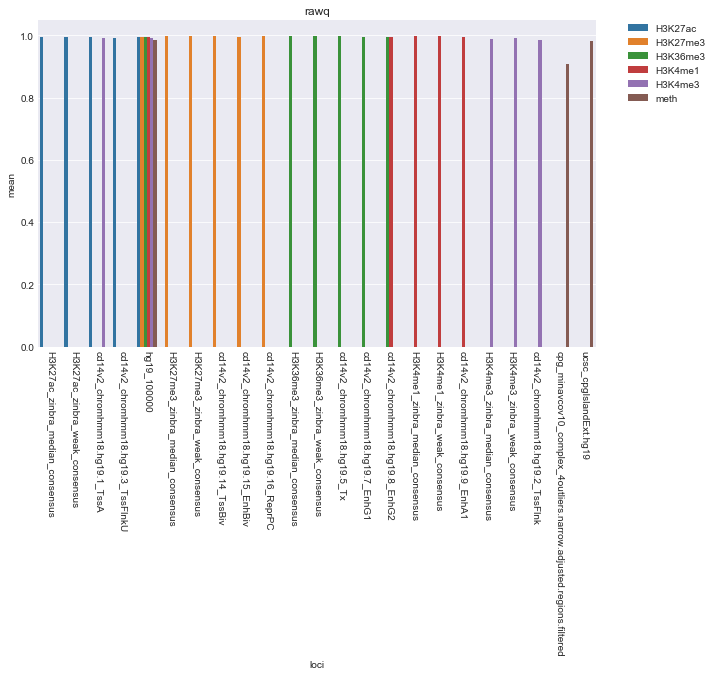

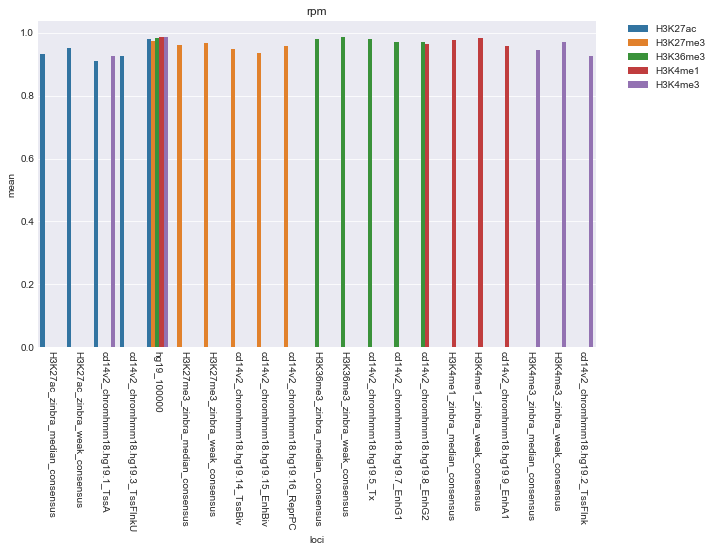

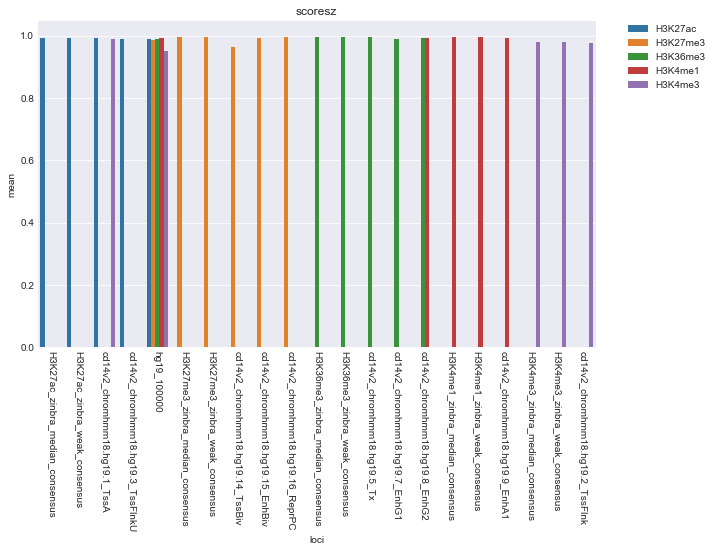

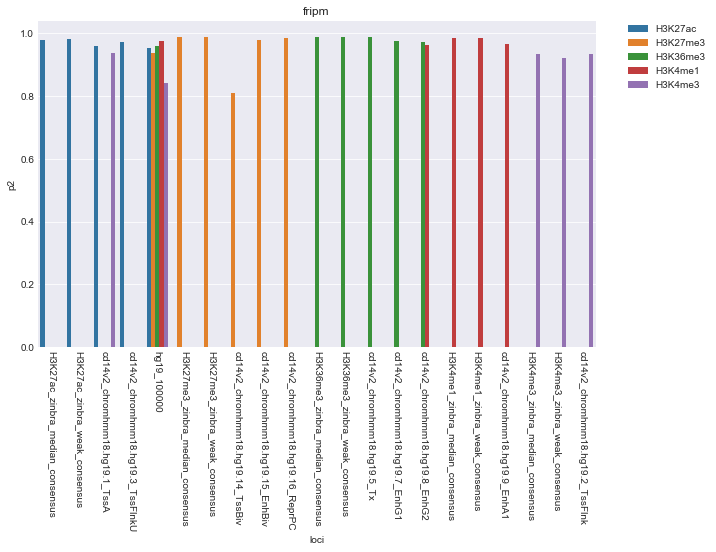

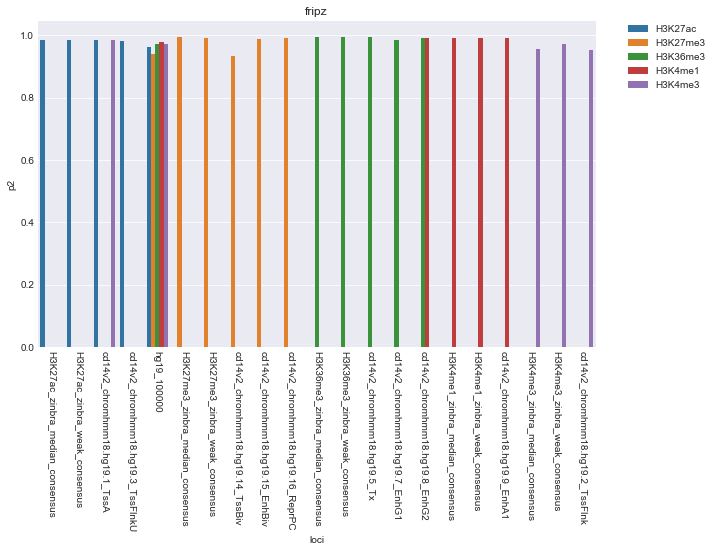

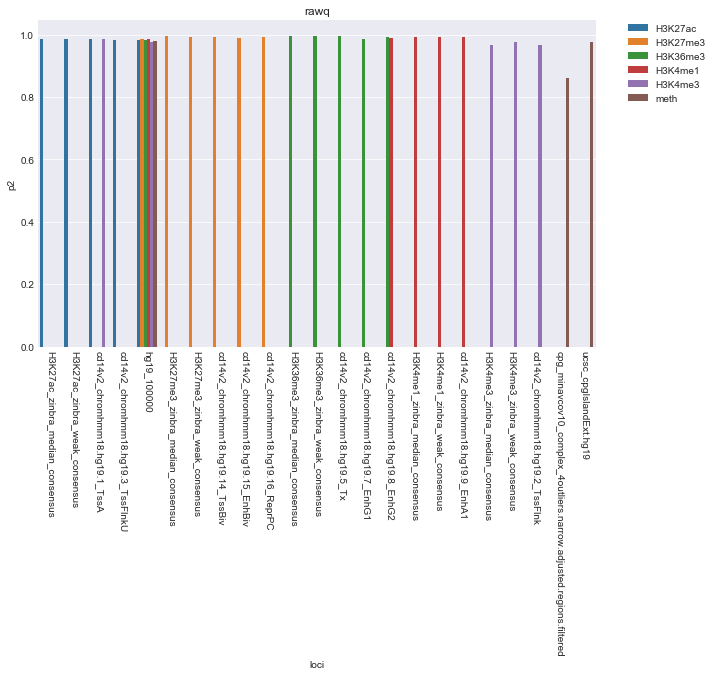

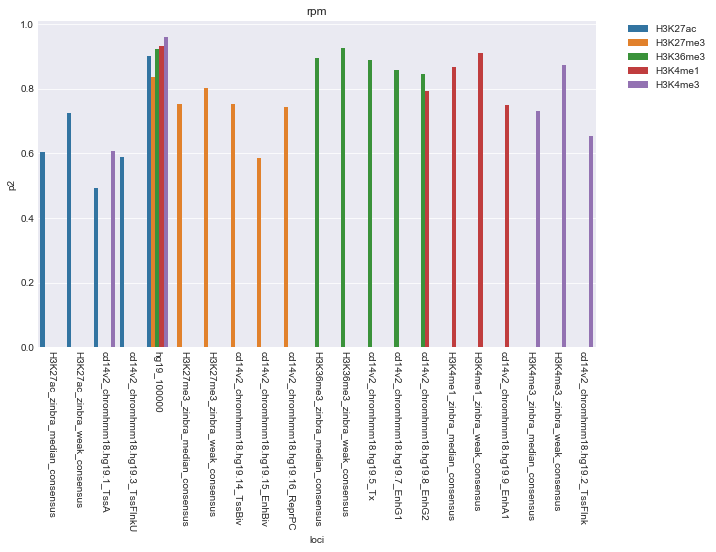

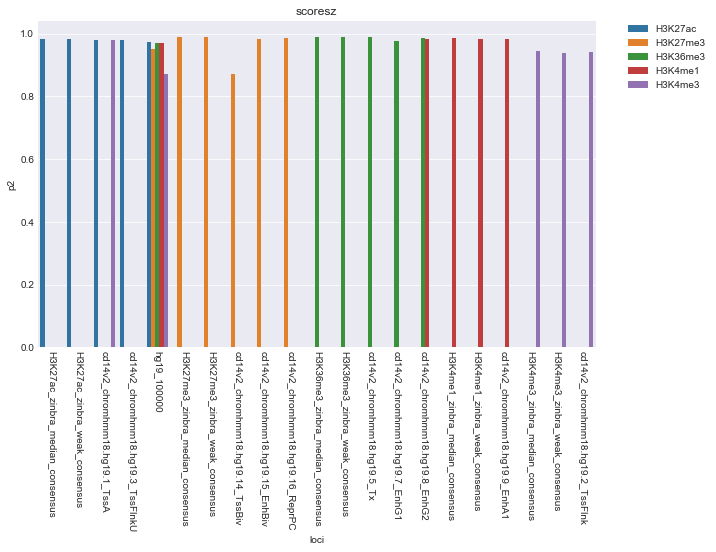

In [50]:
for metric in ["mean", "p2"]:
    for norm in ["fripm", "fripz", "rawq", "rpm", "scoresz"]:
        plt.figure(figsize=(10,6))
        g = sns.barplot(data=df[df["normalization"] == norm], y=metric, x="loci", hue="modification")
        for item in g.get_xticklabels():
            item.set_rotation(-90)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        #plt.yscale("log")
        plt.title(norm)
        plt.show()

So: "fripz", "rawq"